# FORECASTING DE VENTAS MOTOS

In [1]:
%pip install pandas seaborn matplotlib pmdarima statsmodels scikit-learn skforecast tensorflow keras


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip show tensorflow


Name: tensorflow
Version: 2.17.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\users\edwin luna\appdata\roaming\python\python39\site-packages
Requires: tensorflow-intel
Required-by: 
Note: you may need to restart the kernel to use updated packages.


# IMPORTANDO LIBRERIAS

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')
import re
import warnings
import matplotlib.dates as mdates
import numpy as np
from io import StringIO
import contextlib
from sklearn import metrics
import plotly.express as px
from sklearn.model_selection import ParameterGrid

#LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Input
from keras import regularizers
from keras.layers import Dropout
from keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator


# pmdarima
from pmdarima import ARIMA
from pmdarima import auto_arima

# statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# skforecast
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.base import BaseEstimator, RegressorMixin

C:\Users\edwin luna\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# IMPORTAMOS LOS DATOS

In [4]:
# Ignora el aviso al leer el archivo
datos = pd.read_csv('ventas_africa_twin_2003_2023.csv', low_memory=False)

In [5]:
datos.head()

ref_fecha  ref_doc_venta_neta
0  2003-01-31        60000.000000
1  2003-02-28        60510.000000
2  2003-03-31        65436.443609
3  2003-04-30        82570.547448
4  2003-05-31        60312.400574

In [6]:
datos['ref_fecha'] = pd.to_datetime(datos['ref_fecha'], format='%Y-%m-%d')
datos = datos.set_index('ref_fecha')
datos = datos.asfreq('ME')
display(datos.head(4))

ref_doc_venta_neta
ref_fecha                     
2003-01-31        60000.000000
2003-02-28        60510.000000
2003-03-31        65436.443609
2003-04-30        82570.547448

In [7]:
ventas_mensuales = datos.copy()

FUNCION PARA EVALUAR

In [8]:
def evaluacion_metrica(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [9]:
# Verificar valores nulos en la serie
print("Valores nulos en la serie original:")
print(datos.isnull().sum())

# Verificar si hay infinitos
print("\nValores infinitos en la serie original:")
print(np.isinf(datos).sum())


Valores nulos en la serie original:
ref_doc_venta_neta    0
dtype: int64

Valores infinitos en la serie original:
ref_doc_venta_neta    0
dtype: int64


In [10]:
import pandas as pd
import numpy as np

# Supongamos que 'datos' es tu DataFrame original
# Verificar valores nulos en la serie
print("Valores nulos en la serie original:")
print(datos.isnull().sum())

# Muestra las filas con valores nulos en ref_doc_venta_neta
nulos = datos[datos['ref_doc_venta_neta'].isnull()]
print("\nFilas con valores nulos en 'ref_doc_venta_neta':")
print(nulos)

# Verificar si hay infinitos
print("\nValores infinitos en la serie original:")
print(np.isinf(datos).sum())

# Muestra las filas con valores infinitos en ref_doc_venta_neta
infinitos = datos[np.isinf(datos['ref_doc_venta_neta'])]
print("\nFilas con valores infinitos en 'ref_doc_venta_neta':")
print(infinitos)



Valores nulos en la serie original:
ref_doc_venta_neta    0
dtype: int64

Filas con valores nulos en 'ref_doc_venta_neta':
Empty DataFrame
Columns: [ref_doc_venta_neta]
Index: []

Valores infinitos en la serie original:
ref_doc_venta_neta    0
dtype: int64

Filas con valores infinitos en 'ref_doc_venta_neta':
Empty DataFrame
Columns: [ref_doc_venta_neta]
Index: []


# ESTACIONARIEDAD

Test estacionariedad serie original
-------------------------------------
ADF Statistic: 0.19236960373425951, p-value: 0.9718303663377401
KPSS Statistic: 2.375778965202474, p-value: 0.01

Test estacionariedad para serie diferenciada (order=1)
--------------------------------------------------
ADF Statistic: -5.731997535310521, p-value: 6.567628488857936e-07
KPSS Statistic: 0.007137177445239027, p-value: 0.1

Test estacionariedad para serie diferenciada (order=2)
--------------------------------------------------
ADF Statistic: -12.051353434740491, p-value: 2.592969342016983e-22
KPSS Statistic: 0.029450753767947743, p-value: 0.1


<Axes: title={'center': 'Diferenciación orden 2'}, xlabel='ref_fecha'>

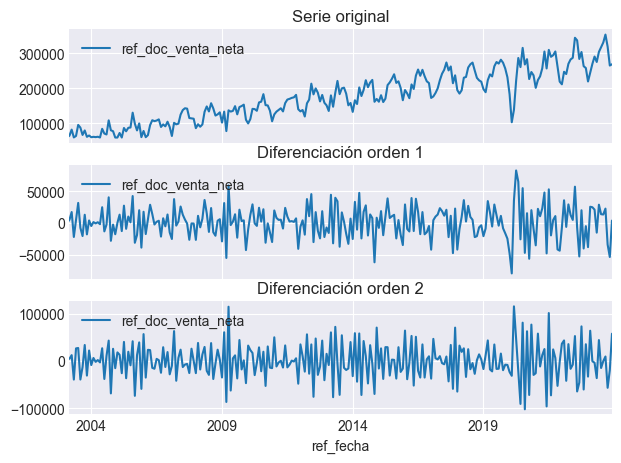

In [11]:
# Test estacionariedad
# ==============================================================================
warnings.filterwarnings("ignore")

datos_diff_1 = datos.diff().dropna()
datos_diff_2 = datos_diff_1.diff().dropna()

print('Test estacionariedad serie original')
print('-------------------------------------')
adfuller_result = adfuller(datos)
kpss_result = kpss(datos)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=1)')
print('--------------------------------------------------')
adfuller_result = adfuller(datos_diff_1)
kpss_result = kpss(datos.diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=2)')
print('--------------------------------------------------')
adfuller_result = adfuller(datos_diff_2)
kpss_result = kpss(datos.diff().diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

warnings.filterwarnings("default")

# Gráfico series
# ==============================================================================
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7, 5), sharex=True)
datos.plot(ax=axs[0], title='Serie original')
datos_diff_1.plot(ax=axs[1], title='Diferenciación orden 1')
datos_diff_2.plot(ax=axs[2], title='Diferenciación orden 2')


 ADF
 Hipótesis nula ( HO ): La serie tiene una raíz unitaria, no es estacionaria.
 Hipótesis alternativa ( HA ): La serie no tiene raíz unitaria, es estacionaria.

KPSS
 Hipótesis nula ( HO ): La serie es estacionaria.
 Hipótesis alternativa ( HA ): La serie no es estacionaria.

 En base a las Pruebas de Dickey-Fuller aumentada y Kwiatkowski-Phillips-Schmidt-Shin (KPSS)
 se comprueba que la serie original no es estacionaria


# ANÁLISIS DE AUTOCORRELACIÓN

Text(0.5, 1.0, 'Autocorrelación serie diferenciada (order=1)')

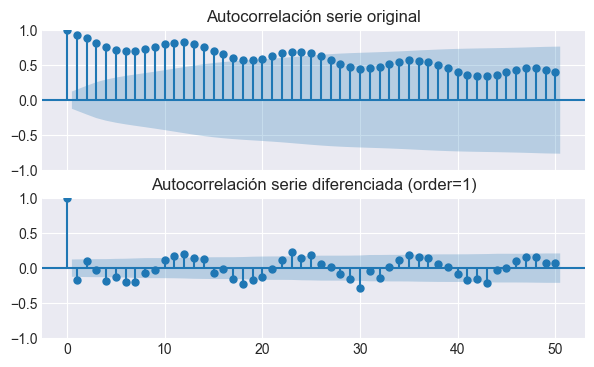

In [12]:
# Grafico de autocorrelación para la serie original y la serie diferenciada
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 4), sharex=True)
plot_acf(datos, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación serie original')
plot_acf(datos_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autocorrelación serie diferenciada (order=1)')


 La ACF presenta un patron sinusoidal por lo que se sugiere la presencia de estacionalidad (12)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


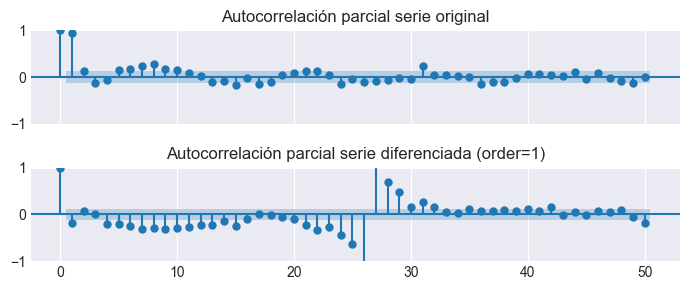

In [13]:
# Autocorrelación parcial para la serie original y la serie diferenciada
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 3), sharex=True)
plot_pacf(datos, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación parcial serie original')
plot_pacf(datos_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autocorrelación parcial serie diferenciada (order=1)');
plt.tight_layout()

## DESCOMPOSICIÓN DE SERIES TEMPORALES

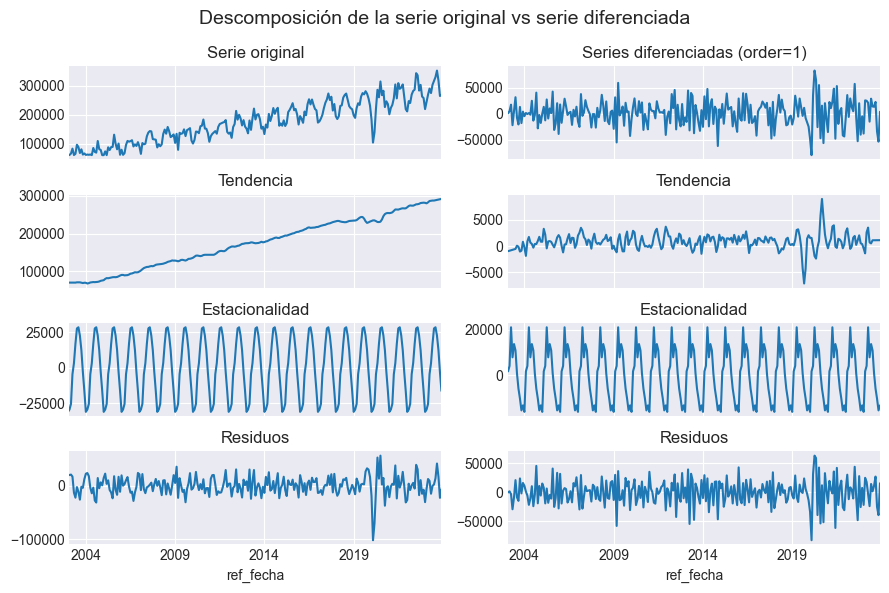

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Descomposición de la serie original y la serie diferenciada
# ==============================================================================

# Asegúrate de definir correctamente el periodo de la estacionalidad (ejemplo: 12 si es anual)
periodo = 12  # Cambia esto si la frecuencia de tus datos es diferente

# Descomponer la serie original
res_decompose = seasonal_decompose(datos, model='additive', period=periodo, extrapolate_trend='freq')

# Descomponer la serie diferenciada
res_descompose_diff_2 = seasonal_decompose(datos_diff_1, model='additive', period=periodo, extrapolate_trend='freq')

# Crear subplots para visualizar las descomposiciones
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(9, 6), sharex=True)

# Serie original
res_decompose.observed.plot(ax=axs[0, 0])
axs[0, 0].set_title('Serie original')
res_decompose.trend.plot(ax=axs[1, 0])
axs[1, 0].set_title('Tendencia')
res_decompose.seasonal.plot(ax=axs[2, 0])
axs[2, 0].set_title('Estacionalidad')
res_decompose.resid.plot(ax=axs[3, 0])
axs[3, 0].set_title('Residuos')

# Serie diferenciada (order=1)
res_descompose_diff_2.observed.plot(ax=axs[0, 1])
axs[0, 1].set_title('Series diferenciadas (order=1)')
res_descompose_diff_2.trend.plot(ax=axs[1, 1])
axs[1, 1].set_title('Tendencia')
res_descompose_diff_2.seasonal.plot(ax=axs[2, 1])
axs[2, 1].set_title('Estacionalidad')
res_descompose_diff_2.resid.plot(ax=axs[3, 1])
axs[3, 1].set_title('Residuos')

# Título general y ajuste del diseño
fig.suptitle('Descomposición de la serie original vs serie diferenciada', fontsize=14)
fig.tight_layout()
plt.show()


El patron recurrente cada 12 meses sugiere una estacionalidad anual confirmando lo observado en el gráfico ACF ya que se observan picos significativos en los lags correspondientes a los intervalos de 12 meses, confirmando la idea de
patrones recurrentes


In [15]:
# Diferenciaciación de orden 1 combinada con diferenciación estacional
# ==============================================================================
datos_diff_1_12 = datos.diff().diff(12).dropna()

warnings.filterwarnings("ignore")
adfuller_result = adfuller(datos_diff_1_12)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
kpss_result = kpss(datos_diff_1_12)
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')
warnings.filterwarnings("default")

ADF Statistic: -7.0817856600731, p-value: 4.646153750206126e-10
KPSS Statistic: 0.04689622946306447, p-value: 0.1


1. Prueba ADF (Augmented Dickey-Fuller):
Hipótesis nula (H0): La serie tiene una raíz unitaria, es decir, no es estacionaria.
Hipótesis alternativa (H1): La serie es estacionaria.
Interpretación:
ADF Statistic: -6.35
p-value: 2.61e-08 (muy bajo)
Dado que el valor p es mucho menor que el nivel de significancia comúnmente usado (como 0.05), rechazas la hipótesis nula. Esto significa que, según la prueba ADF, la serie diferenciada (combinación de diferenciación de orden 1 y diferenciación estacional) es estacionaria.

2. Prueba KPSS (Kwiatkowski-Phillips-Schmidt-Shin):
Hipótesis nula (H0): La serie es estacionaria.
Hipótesis alternativa (H1): La serie tiene una tendencia o no es estacionaria.
Interpretación:
KPSS Statistic: 0.030
p-value: 0.1
Aquí el valor p es mayor que 0.05, por lo que no rechazas la hipótesis nula.

Según la prueba KPSS, la serie es estacionaria.Con base en los resultados del análisis exploratorio, emplear una combinación de diferenciación de primer orden y diferenciación estacional podría ser el método más adecuado. La diferenciación de primer orden es útil para captar las transiciones entre observaciones y destacar las fluctuaciones a corto plazo. A su vez, la diferenciación estacional, que abarca un período de 12 meses y refleja el cambio anual, permite capturar los patrones cíclicos presentes en los datos. Esta estrategia facilita alcanzar la estacionariedad requerida para el posterior modelado ARIMA.

# SEPARAMOS LOS DATOS EN TRAIN Y TEST

Fechas train : 2003-01-31 00:00:00 --- 2017-09-30 00:00:00  (n=177)
Fechas test  : 2017-10-31 00:00:00 --- 2023-12-31 00:00:00  (n=75)


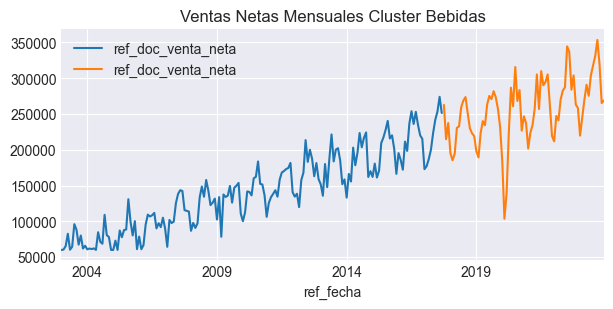

In [16]:
# Calcular la fecha de corte para dividir entre entrenamiento y prueba (80-20 split)
fin_train = datos.index[int(len(datos) * 0.7)]

# Dividir los datos en conjunto de entrenamiento y prueba
datos_train = datos.loc[datos.index <= fin_train]
datos_test = datos.loc[datos.index > fin_train]
test=datos_test.copy()
train=datos_train.copy()

# Imprimir la longitud de los conjuntos de entrenamiento y prueba
print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

# Gráfico
# ======================================================================================
fig, ax=plt.subplots(figsize=(7, 3))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
ax.set_title('Ventas Netas Mensuales Cluster Bebidas')
ax.legend()
plt.show()


# MODELO ARIMA-SARIMAX

## STATSMODELS

In [17]:
# Modelo SARIMAX con statsmodels.Sarimax
# ==============================================================================
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
modelo = SARIMAX(endog = datos_train, order = (1, 1, 1), seasonal_order = (1, 1, 1, 12))
modelo_res = modelo.fit(disp=0)
warnings.filterwarnings("default")
modelo_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                 ref_doc_venta_neta   No. Observations:                  177
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1849.481
Date:                            Tue, 01 Oct 2024   AIC                           3708.962
Time:                                    21:39:47   BIC                           3724.461
Sample:                                01-31-2003   HQIC                          3715.254
                                     - 09-30-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0559      0.206      0.271      0.786      -0.348       0.459
ma.L1         -0.7966      0.126     -6.340      0.000      -1.043      -0.550
ar.S.L12      -0.1690      0.191     -0.885      0.376      -0.543       0.205
ma.S.L12      -0.6727      0.186     -3.614      0.000      -1.037      -0.308
sigma2       5.63e+08   9.45e-11   5.96e+18      0.000    5.63e+08    5.63e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.59   Jarque-Bera (JB):                 1.32
Prob(Q):                              0.44   Prob(JB):                         0.52
Heteroskedasticity (H):               0.88   Skew:                            -0.12
Prob(H) (two-sided):                  0.62   Kurtosis:                         2.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.12e+36. Standard errors may be unstable.
"""

In [18]:
# Predicción
# ==============================================================================
predicciones_statsmodels = modelo_res.get_forecast(steps=len(datos_test)).predicted_mean
predicciones_statsmodels.name = 'predicciones_statsmodels'
display(predicciones_statsmodels)

2017-10-31    245804.405842
2017-11-30    224116.230737
2017-12-31    209511.679507
2018-01-31    204954.127822
2018-02-28    210470.969682
                  ...      
2023-08-31    335149.221188
2023-09-30    329322.812777
2023-10-31    322221.628652
2023-11-30    301552.185262
2023-12-31    288345.872917
Freq: ME, Name: predicciones_statsmodels, Length: 75, dtype: float64

In [19]:
# Llamar a la función de evaluación de métricas
evaluacion_metrica(datos_test['ref_doc_venta_neta'], predicciones_statsmodels)

Evaluation metric results:-
MSE is : 782443785.344215
MAE is : 19589.721329554184
RMSE is : 27972.196648533256
MAPE is : 9.351130206779116
R2 is : 0.6025238030389476



## Modelo SARIMAX con skforecast.Sarimax 

In [20]:
# Modelo SARIMAX con skforecast.Sarimax
# ==============================================================================
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
modelo = Sarimax(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
modelo.fit(y=datos_train)
modelo.summary()
warnings.filterwarnings("default")

In [21]:
# Predictión
# ==============================================================================
predicciones_skforecast = modelo.predict(steps=len(datos_test))
display(predicciones_skforecast.head(4))

pred
2017-10-31  245804.405842
2017-11-30  224116.230737
2017-12-31  209511.679507
2018-01-31  204954.127822

In [22]:
# Llamar a la función de evaluación de métricas
evaluacion_metrica(datos_test['ref_doc_venta_neta'], predicciones_skforecast)

Evaluation metric results:-
MSE is : 782443785.344215
MAE is : 19589.721329554184
RMSE is : 27972.196648533256
MAPE is : 19.95707469246107
R2 is : 0.6025238030389476



## PDMARIMA

In [23]:
# Modelo SARIMAX con pdmarima.Sarimax
# ==============================================================================
modelo = ARIMA(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
modelo.fit(y=datos_train)
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  177
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1851.349
Date:                            Tue, 01 Oct 2024   AIC                           3714.697
Time:                                    21:39:48   BIC                           3733.296
Sample:                                01-31-2003   HQIC                          3722.248
                                     - 09-30-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    335.9614    471.910      0.712      0.477    -588.965    1260.888
ar.L1         -0.0872      0.219     -0.399      0.690      -0.516       0.342
ma.L1         -0.6518      0.174     -3.745      0.000      -0.993      -0.311
ar.S.L12      -0.1845      0.199     -0.928      0.353      -0.574       0.205
ma.S.L12      -0.6277      0.189     -3.326      0.001      -0.998      -0.258
sigma2      5.629e+08      0.000   1.43e+12      0.000    5.63e+08    5.63e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.45   Jarque-Bera (JB):                 0.63
Prob(Q):                              0.50   Prob(JB):                         0.73
Heteroskedasticity (H):               0.91   Skew:                            -0.06
Prob(H) (two-sided):                  0.74   Kurtosis:                         2.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.26e+28. Standard errors may be unstable.
"""

In [24]:
# Prediction
# ==============================================================================
predicciones_pdmarima = modelo.predict(len(datos_test))
predicciones_pdmarima.name = 'predicciones_pdmarima'
display(predicciones_pdmarima.head(4))

2017-10-31    251538.754067
2017-11-30    229142.895592
2017-12-31    215517.239680
2018-01-31    211676.132417
Freq: ME, Name: predicciones_pdmarima, dtype: float64

In [25]:
# Llamar a la función de evaluación de métricas
evaluacion_metrica(datos_test['ref_doc_venta_neta'], predicciones_pdmarima)

Evaluation metric results:-
MSE is : 6065287612.127911
MAE is : 66107.67060328052
RMSE is : 77879.95642094254
MAPE is : 27.383836818387714
R2 is : -2.0811254414692746



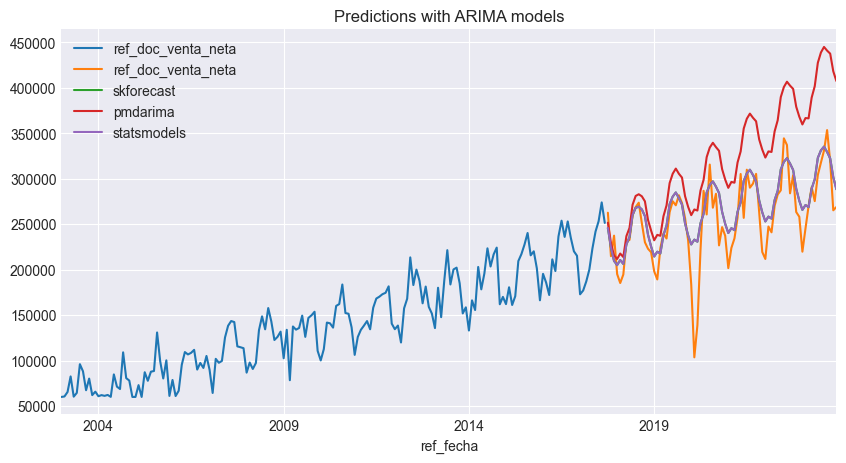

In [26]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 5))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predicciones_skforecast.columns = ['skforecast']
predicciones_skforecast.plot(ax=ax, label='skforecast')
predicciones_pdmarima.plot(ax=ax, label='pmdarima')
predicciones_statsmodels.plot(ax=ax, label='statsmodels')
ax.set_title('Predictions with ARIMA models')
ax.legend()

## FORECASTERSARIMAX

In [27]:
datos_train = datos_train['ref_doc_venta_neta']

In [28]:
# Modelo ARIMA con ForecasterSarimax y skforecast Sarimax
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
             )
forecaster.fit(y=datos_train, suppress_warnings=True)

# Predicción
predicciones = forecaster.predict(steps=len(datos_test))
predicciones.head(4)

2017-10-31    245804.405842
2017-11-30    224116.230737
2017-12-31    209511.679507
2018-01-31    204954.127822
Freq: ME, Name: pred, dtype: float64

In [29]:
# Llamar a la función de evaluación de métricas
evaluacion_metrica(datos_test['ref_doc_venta_neta'], predicciones)

Evaluation metric results:-
MSE is : 782443785.344215
MAE is : 19589.721329554184
RMSE is : 27972.196648533256
MAPE is : 9.351130206779116
R2 is : 0.6025238030389476



## BACKTESTING

In [30]:
datos = datos['ref_doc_venta_neta']

In [31]:
# Backtest forecaster
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                maxiter=500
                            )
             )

metrica, predicciones = backtesting_sarimax(
                            forecaster            = forecaster,
                            y                     = datos,
                            initial_train_size    = len(datos_train),
                            fixed_train_size      = False,
                            steps                 = 12,
                            metric                = 'mean_absolute_error',
                            refit                 = True,
                            n_jobs                = "auto",
                            suppress_warnings_fit = True,
                            verbose               = True,
                            show_progress         = True
                        )

print(f"Metrica (mean absolute error): {metrica}")
display(predicciones.head(4))

Information of backtesting process
----------------------------------
Number of observations used for initial training: 177
Number of observations used for backtesting: 75
    Number of folds: 7
    Number skipped folds: 0 
    Number of steps per fold: 12
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 3 observations.

Fold: 0
    Training:   2003-01-31 00:00:00 -- 2017-09-30 00:00:00  (n=177)
    Validation: 2017-10-31 00:00:00 -- 2018-09-30 00:00:00  (n=12)
Fold: 1
    Training:   2003-01-31 00:00:00 -- 2018-09-30 00:00:00  (n=189)
    Validation: 2018-10-31 00:00:00 -- 2019-09-30 00:00:00  (n=12)
Fold: 2
    Training:   2003-01-31 00:00:00 -- 2019-09-30 00:00:00  (n=201)
    Validation: 2019-10-31 00:00:00 -- 2020-09-30 00:00:00  (n=12)
Fold: 3
    Training:   2003-01-31 00:00:00 -- 2020-09-30 00:00:00  (n=213)
    Validation: 2020-10-31 00:00:00 -- 2021-09-30 00:00:00  (n=12)
Fold: 4
    Training:   2003-01-31 00:00:00

  0%|          | 0/7 [00:00<?, ?it/s]

Metrica (mean absolute error):    mean_absolute_error
0         17849.413909


pred
2017-10-31  245804.405842
2017-11-30  224116.230737
2017-12-31  209511.679507
2018-01-31  204954.127822

In [32]:
# Llamar a la función de evaluación de métricas
evaluacion_metrica(datos_test['ref_doc_venta_neta'], predicciones)

Evaluation metric results:-
MSE is : 636794030.578176
MAE is : 17849.41390883231
RMSE is : 25234.778195541487
MAPE is : 19.098336364910786
R2 is : 0.6765129019328022



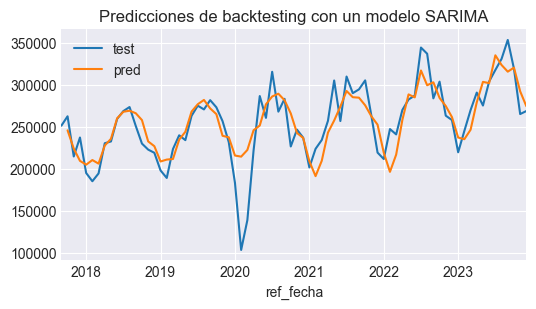

In [33]:
# Gráfico predicciones de backtesting
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
datos.loc[fin_train:].plot(ax=ax, label='test')
predicciones.plot(ax=ax)
ax.set_title('Predicciones de backtesting con un modelo SARIMA')
ax.legend()

## BUSQUEDA DE HIPERPARAMETROS p,d,q

Fechas entrenamiento : 2003-01-31 00:00:00 --- 2010-01-31 00:00:00  (n=85)
Fechas validacion    : 2010-02-28 00:00:00 --- 2018-01-31 00:00:00  (n=96)
Fechas test          : 2018-02-28 00:00:00 --- 2023-12-31 00:00:00  (n=71)


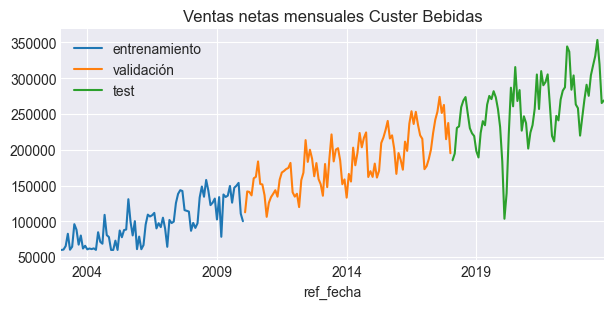

In [34]:
# Definir las fechas de corte
fin_train = '2010-02-01 23:59:59'
fin_val = '2018-02-01 23:59:59'
print(
    f"Fechas entrenamiento : {datos.index.min()} --- {datos.loc[:fin_train].index.max()}  "
    f"(n={len(datos.loc[:fin_train])})"
)
print(
    f"Fechas validacion    : {datos.loc[fin_train:].index.min()} --- {datos.loc[:fin_val].index.max()}  "
    f"(n={len(datos.loc[fin_train:fin_val])})"
)
print(
    f"Fechas test          : {datos.loc[fin_val:].index.min()} --- {datos.index.max()}  "
    f"(n={len(datos.loc[fin_val:])})"
)

# Gráfico
# ======================================================================================
fig, ax = plt.subplots(figsize=(7, 3))
datos.loc[:fin_train].plot(ax=ax, label='entrenamiento')
datos.loc[fin_train:fin_val].plot(ax=ax, label='validación')
datos.loc[fin_val:].plot(ax=ax, label='test')
ax.set_title('Ventas netas mensuales Custer Bebidas')
ax.legend();

In [35]:
# Grid search basado en backtesting
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(
                                order=(1, 1, 1), # Placeholder replaced in the grid search
                                maxiter=500
                            )
             )

param_grid = {
    'order': [(1, 0, 1), (1, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 1, 0), (1, 1, 1), (2, 1, 1), (2, 1, 0), (0, 1, 2)],
    'seasonal_order': [(0, 0, 0, 0), (0, 1, 0, 12), (1, 1, 1, 12), (0, 1, 1, 12), (1, 1, 0, 12), (1, 0, 1, 12)],
    'trend': [None, 'n', 'c']
}

resultados_grid = grid_search_sarimax(
                        forecaster            = forecaster,
                        y                     = datos.loc[:fin_val],
                        param_grid            = param_grid,
                        steps                 = 12,
                        refit                 = True,
                        metric                = 'mean_absolute_error',
                        initial_train_size    = len(datos_train),
                        fixed_train_size      = False,
                        return_best           = False,
                        n_jobs                = 'auto',
                        suppress_warnings_fit = True,
                        verbose               = False,
                        show_progress         = True
                   )

resultados_grid.head(5)

Number of models compared: 180.


params grid:   0%|          | 0/180 [00:00<?, ?it/s]

params  mean_absolute_error  \
95   {'order': (1, 1, 0), 'seasonal_order': (0, 1, ...          9775.384120   
93   {'order': (1, 1, 0), 'seasonal_order': (0, 1, ...          9899.224371   
94   {'order': (1, 1, 0), 'seasonal_order': (0, 1, ...          9899.224371   
113  {'order': (1, 1, 1), 'seasonal_order': (0, 1, ...         12640.734206   
167  {'order': (0, 1, 2), 'seasonal_order': (0, 1, ...         12646.653704   

         order seasonal_order trend  
95   (1, 1, 0)  (0, 1, 0, 12)     c  
93   (1, 1, 0)  (0, 1, 0, 12)  None  
94   (1, 1, 0)  (0, 1, 0, 12)     n  
113  (1, 1, 1)  (0, 1, 0, 12)     c  
167  (0, 1, 2)  (0, 1, 0, 12)     c

In [36]:
# Auto arima: seleccion basada en AIC
# ==============================================================================
modelo = auto_arima(
            y                 = datos.loc[:fin_val],
            start_p           = 0,
            start_q           = 0,
            max_p             = 4,
            max_q             = 4,
            seasonal          = True,
            test              = 'adf',
            m                 = 12, # periodicidad de la estacionalidad
            d                 = None, # El algoritmo determina 'd'
            D                 = None, # El algoritmo determina 'D'
            trace             = True,
            error_action      = 'ignore',
            suppress_warnings = True,
            stepwise          = True
        )

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=4377.881, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=4465.189, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=4135.173, Time=0.06 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=4345.697, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=4838.200, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=4134.798, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=4135.374, Time=0.04 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=4136.876, Time=0.22 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=4119.960, Time=0.03 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=4110.267, Time=0.11 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=4104.911, Time=0.20 sec
 ARIMA(2,0,0)(2,0,1)[12] intercept   : AIC=4105.276, Time=0.27 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=4107.517, Time=0.21 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=4135.062, Time=0.14 sec
 ARIMA(3,0,0)(2,0,0

In [37]:
# Predicciones de backtesting con el mejor modelo según el grid search
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(4, 0, 4), seasonal_order=(1, 0, 1, 12), maxiter=500),
             )

metrica_m1, predicciones_m1 = backtesting_sarimax(
                                forecaster            = forecaster,
                                y                     = datos,
                                initial_train_size    = len(datos.loc[:fin_val]),
                                steps                 = 12,
                                metric                = 'mean_absolute_error',
                                refit                 = True,
                                n_jobs                = "auto",
                                suppress_warnings_fit = True,
                                verbose               = False,
                                show_progress         = True
                            )

# Predicciones de backtesting con el mejor modelo según auto arima
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(4, 0, 4), seasonal_order=(2, 0, 1, 12), maxiter=500),
             )

metrica_m2, predicciones_m2 = backtesting_sarimax(
                                forecaster            = forecaster,
                                y                     = datos,
                                initial_train_size    = len(datos.loc[:fin_val]),
                                steps                 = 12,
                                metric                = 'mean_absolute_error',
                                refit                 = True,
                                n_jobs                = "auto",
                                suppress_warnings_fit = True,
                                verbose               = False,
                                show_progress         = True
                            )

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Metrica (mean absolute error) del modelo grid search :    mean_absolute_error
0         19709.688766
Metric (mean_absolute_error) del modelo auto arima   :    mean_absolute_error
0         19833.703512


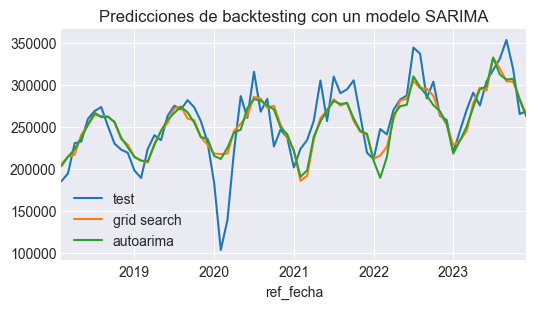

In [38]:
# Comparación de métricas
# ==============================================================================
print(f"Metrica (mean absolute error) del modelo grid search : {metrica_m1}")
print(f"Metric (mean_absolute_error) del modelo auto arima   : {metrica_m2}")

fig, ax = plt.subplots(figsize=(6, 3))
datos.loc[fin_val:].plot(ax=ax, label='test')
predicciones_m1 = predicciones_m1.rename(columns={'pred': 'grid search'})
predicciones_m2 = predicciones_m2.rename(columns={'pred': 'autoarima'})
predicciones_m1.plot(ax=ax)
predicciones_m2.plot(ax=ax)
ax.set_title('Predicciones de backtesting con un modelo SARIMA')
ax.legend()

# PROYECCION CON MODELO HOLT WINTERS ADITIVO

In [39]:
# Definir el modelo Holt-Winters
modelo = ExponentialSmoothing(train['ref_doc_venta_neta'], seasonal='add', seasonal_periods=12)  

# Ajustar el modelo con los datos de entrenamiento
resultado = modelo.fit()

# Realizar predicciones en el conjunto de prueba
predicciones = resultado.predict(start=datos_test.index[0], end=datos_test.index[-1])

# Crear un DataFrame separado para almacenar las predicciones
predicciones_df = pd.DataFrame({'Fecha': datos_test.index, 'Venta_Real': datos_test['ref_doc_venta_neta'], 'Ventas_Proyectadas': predicciones})

# Imprimir los resultados
print(predicciones_df)

                Fecha     Venta_Real  Ventas_Proyectadas
2017-10-31 2017-10-31  262508.190440       234445.973245
2017-11-30 2017-11-30  214719.390529       220939.586482
2017-12-31 2017-12-31  237284.609212       207367.638793
2018-01-31 2018-01-31  195074.253244       199539.837434
2018-02-28 2018-02-28  185250.206375       204330.145035
...               ...            ...                 ...
2023-08-31 2023-08-31  330801.655137       253015.514136
2023-09-30 2023-09-30  353326.435118       244026.375030
2023-10-31 2023-10-31  319066.757537       234445.973245
2023-11-30 2023-11-30  265178.374151       220939.586482
2023-12-31 2023-12-31  268767.929206       207367.638793

[75 rows x 3 columns]


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


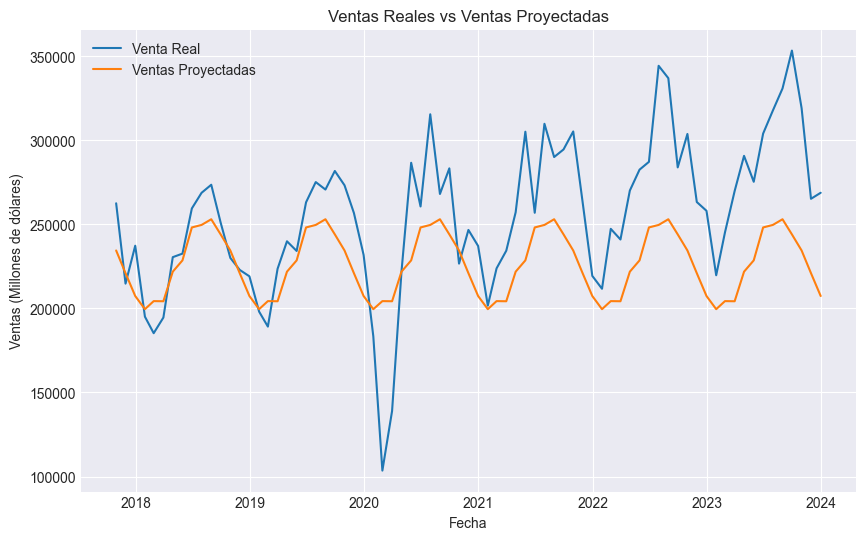

In [40]:
# Graficar las ventas reales y suavizadas
plt.figure(figsize=(10, 6))
plt.plot(predicciones_df['Fecha'], predicciones_df['Venta_Real'], label='Venta Real')
plt.plot(predicciones_df['Fecha'], predicciones_df['Ventas_Proyectadas'], label='Ventas Proyectadas')
plt.title('Ventas Reales vs Ventas Proyectadas')
plt.xlabel('Fecha')
plt.ylabel('Ventas (Millones de dólares)')
plt.legend()
plt.show()

In [41]:
# Llamar a la función de evaluación de métricas
evaluacion_metrica(datos_test['ref_doc_venta_neta'], predicciones)

Evaluation metric results:-
MSE is : 1973234728.7401998
MAE is : 35715.8691194735
RMSE is : 44421.1067932824
MAPE is : 13.982074915836701
R2 is : -0.0023900123969811116



# PROYECCION CON MODELO HOLT WINTERS MULTIPLICATIVO

In [42]:
# Definir el modelo Holt-Winters
modelo = ExponentialSmoothing(train['ref_doc_venta_neta'], seasonal='mul', seasonal_periods=12)  

# Ajustar el modelo con los datos de entrenamiento
resultado = modelo.fit()

# Realizar predicciones en el conjunto de prueba
predicciones = resultado.predict(start=datos_test.index[0], end=datos_test.index[-1])

# Crear un DataFrame separado para almacenar las predicciones
predicciones_df = pd.DataFrame({'Fecha': datos_test.index, 'Venta_Real': datos_test['ref_doc_venta_neta'], 'Ventas_Proyectadas': predicciones})

# Imprimir los resultados
print(predicciones_df)

                Fecha     Venta_Real  Ventas_Proyectadas
2017-10-31 2017-10-31  262508.190440       233042.474646
2017-11-30 2017-11-30  214719.390529       221866.819830
2017-12-31 2017-12-31  237284.609212       194823.986065
2018-01-31 2018-01-31  195074.253244       186363.915797
2018-02-28 2018-02-28  185250.206375       180857.474569
...               ...            ...                 ...
2023-08-31 2023-08-31  330801.655137       265853.384154
2023-09-30 2023-09-30  353326.435118       251979.135418
2023-10-31 2023-10-31  319066.757537       233042.474646
2023-11-30 2023-11-30  265178.374151       221866.819830
2023-12-31 2023-12-31  268767.929206       194823.986065

[75 rows x 3 columns]


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


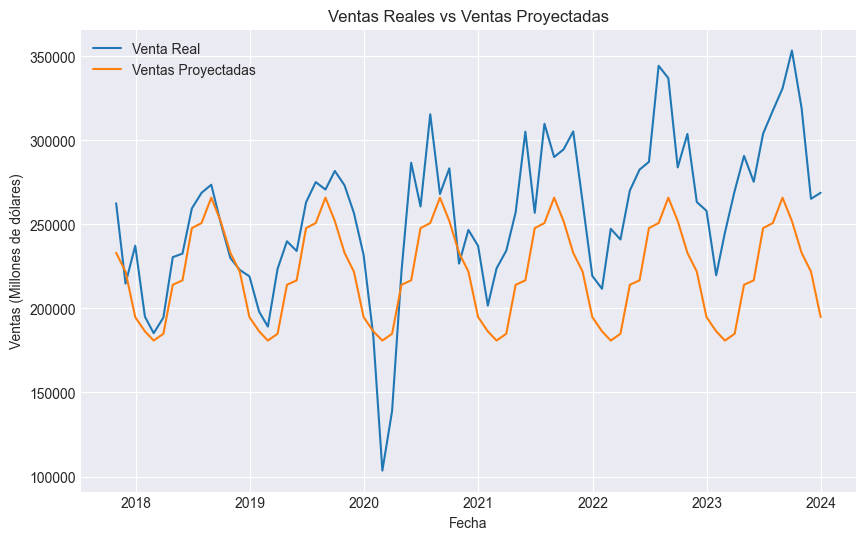

In [43]:
# Graficar las ventas reales y suavizadas
plt.figure(figsize=(10, 6))
plt.plot(predicciones_df['Fecha'], predicciones_df['Venta_Real'], label='Venta Real')
plt.plot(predicciones_df['Fecha'], predicciones_df['Ventas_Proyectadas'], label='Ventas Proyectadas')
plt.title('Ventas Reales vs Ventas Proyectadas')
plt.xlabel('Fecha')
plt.ylabel('Ventas (Millones de dólares)')
plt.legend()
plt.show()

In [44]:
# Llamar a la función de evaluación de métricas
evaluacion_metrica(datos_test['ref_doc_venta_neta'], predicciones)

Evaluation metric results:-
MSE is : 2173904118.45771
MAE is : 38411.7977171626
RMSE is : 46625.14470173481
MAPE is : 14.92444132845627
R2 is : -0.10432871696004731



# BUSQUEDA DE MEJORES HIPERPARAMETROS HOLT WINTERS

In [45]:
# Definir los rangos de valores para los hiperparámetros
param_grid = {
    'trend': ['add', 'mul'],  
    'seasonal': ['add', 'mul'],  
    'seasonal_periods': [12],  
    'smoothing_level': np.linspace(0.1, 1.0, 10),  # Rango de valores para alfa
    'smoothing_trend': np.linspace(0.1, 1.0, 10),  # Rango de valores para beta
    'smoothing_seasonal': np.linspace(0.1, 1.0, 10)  # Rango de valores para gamma
}

# Generar todas las combinaciones de hiperparámetros
param_combinations = list(ParameterGrid(param_grid))

# Función para calcular el MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Inicializar variables para almacenar los mejores hiperparámetros y el mejor modelo
best_score = float('inf')
best_params = None
best_model = None

# Iterar sobre todas las combinaciones de hiperparámetros
for params in param_combinations:
    # Definir y ajustar el modelo Holt-Winters con los hiperparámetros actuales
    modelo = ExponentialSmoothing(train['ref_doc_venta_neta'],
                                  trend=params['trend'],
                                  seasonal=params['seasonal'],
                                  seasonal_periods=params['seasonal_periods'],
                                  initialization_method="estimated")
    resultado = modelo.fit(smoothing_level=params['smoothing_level'],
                           smoothing_trend=params['smoothing_trend'],
                           smoothing_seasonal=params['smoothing_seasonal'])

    # Realizar predicciones en el conjunto de prueba
    predicciones = resultado.predict(start=datos_test.index[0], end=datos_test.index[-1])

    # Calcular el MAPE
    mape = calculate_mape(datos_test['ref_doc_venta_neta'], predicciones)

    # Actualizar los mejores hiperparámetros y el mejor modelo si se encuentra un modelo con un mejor rendimiento
    if mape < best_score:
        best_score = mape
        best_params = params
        best_model = resultado

# Imprimir los mejores hiperparámetros y el mejor modelo
print("Mejores hiperparámetros:", best_params)
print("Error Porcentual Absoluto Medio (MAPE) en conjunto de prueba:", best_score)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retv

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retv

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anacond

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retv

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retv

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1406: RuntimeWarning: overflow encountered in matmul
  sse = err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1406: RuntimeWarning: overflow encountered in matmul
  sse = err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.p

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\s

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\ProgramData\Anaconda3\l

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retv

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anacond

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1406: RuntimeWarning: overflow encountered in matmul
  sse = err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1406: RuntimeWarning: overflow encountered in matmul
  sse = err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\sta

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1406: RuntimeWarning: overflow encountered in matmul
  sse = err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1406: RuntimeWarning: overflow encountered in matmul
  sse = err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sta

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1406: RuntimeWarning: overflow encountered in matmul
  sse = err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1406: RuntimeWarning: overflow encountered in matmul
  sse = err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinte

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1363: RuntimeWarning: overflow encountered in multiply
  + (alphac * trended(lvls[i - 1], dampen(b[i - 1], phi)))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1371: RuntimeWarning: overflow encountered in multiply
  - (gamma * trended(lvls[i - 1], dampen(b[i - 1], phi)))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1366: RuntimeWarning: invalid val

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anacond

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1363: RuntimeWarning: overflow encountered in multiply
  + (alphac * trended(lvls[i - 1], dampen(b[i - 1], phi)))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1371: RuntimeWarning: overflow encountered in multiply
  - (gamma * trended(lvls[i - 1], dampen(b[i - 1], phi)))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1366: RuntimeWarning: invalid val

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\l

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retv

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retv

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anacond

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1363: RuntimeWarning: overflow encountered in multiply
  + (alphac * trended(lvls[i - 1], damp

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anacond

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anacond

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1363: RuntimeWarning: overflow encountered in multiply
  + (alphac * trended(lvls[i - 1], dampen(b[i - 1], phi)))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1371: RuntimeWarning: overflow encountered in multiply
  - (gamma * trended(lvls[i - 1], dampen(b[i - 1], phi)))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1366: RuntimeWarning: invalid val

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retv

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1379: RuntimeWarning: overflow encountered in power
  b[nobs:] = dampen(b[nobs], phi_h)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1380: RuntimeWarning: overflow encountered in multiply
  trend = trended(lvls, b)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1363: RuntimeWarning: overflow encountered in multiply
  + (alphac * trended(lvls[i - 1], dampen(b[i - 1], phi)))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1363: RuntimeWarning: invalid value encountered in double_scalars
  + (alphac * trended(lvls[i - 1], dampen(b[i - 1], phi)))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1371: RuntimeWarning:

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retv

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retv

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\P

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retv

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1352: RuntimeWarning: overflow encountered in power
  b[nobs:] = dampen(b[nobs], phi_h)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1353: RuntimeWarning: overflow encountered in multiply
  trend = trended(lvls, b)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retv

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1352: RuntimeWarning: overflow encountered in power
  b[nobs:] = dampen(b[nobs], phi_h)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1353: RuntimeWarning: overflow encountered in multiply
  trend = trended(lvls, b)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

Mejores hiperparámetros: {'seasonal': 'add', 'seasonal_periods': 12, 'smoothing_level': 0.2, 'smoothing_seasonal': 0.5, 'smoothing_trend': 0.2, 'trend': 'add'}
Error Porcentual Absoluto Medio (MAPE) en conjunto de prueba: 7.031055858074567


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1338: RuntimeWarning: overflow encountered in multiply
  alphac * trended(lvls[i - 1], dampen(b[i - 1], phi))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1338: RuntimeWarning: invalid value encountered in double_scalars
  alphac * trended(lvls[i - 1], dampen(b[i - 1], phi))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1344: RuntimeWarning: overflow encountered in multiply
  s[i + m - 1] = y_gamma[i - 1] / trended(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1337: RuntimeWarning: divide by zero encountered in double_scalars
  lvls[i] = y_alpha[i - 1] / s[i - 1] + (
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinte

In [46]:
# Definir los hiperparámetros obtenidos
hiperparametros = {
    'seasonal': best_params['seasonal'],
    'seasonal_periods': best_params['seasonal_periods'],
    'smoothing_level': best_params['smoothing_level'],
    'smoothing_seasonal': best_params['smoothing_seasonal'],
    'smoothing_trend': best_params['smoothing_trend'],
    'trend': best_params['trend']
}


# Definir el modelo Holt-Winters sin pasar directamente los hiperparámetros al constructor
modelo = ExponentialSmoothing(train['ref_doc_venta_neta'], seasonal_periods=hiperparametros['seasonal_periods'], trend=hiperparametros['trend'], seasonal=hiperparametros['seasonal'])

# Ajustar el modelo con los datos de entrenamiento y los hiperparámetros obtenidos
resultado = modelo.fit(smoothing_level=hiperparametros['smoothing_level'], smoothing_trend=hiperparametros['smoothing_trend'], smoothing_seasonal=hiperparametros['smoothing_seasonal'])

# Realizar predicciones en el conjunto de prueba
predicciones = resultado.predict(start=datos_test.index[0], end=datos_test.index[-1])

# Crear un DataFrame separado para almacenar las predicciones
predicciones_df = pd.DataFrame({'Fecha': datos_test.index,
                                'Venta_Real': datos_test['ref_doc_venta_neta'],
                                'Ventas_Proyectadas': predicciones})

# Imprimir los resultados
print(predicciones_df)

                Fecha     Venta_Real  Ventas_Proyectadas
2017-10-31 2017-10-31  262508.190440       242314.844569
2017-11-30 2017-11-30  214719.390529       219750.889303
2017-12-31 2017-12-31  237284.609212       205993.641275
2018-01-31 2018-01-31  195074.253244       186922.245222
2018-02-28 2018-02-28  185250.206375       192885.921735
...               ...            ...                 ...
2023-08-31 2023-08-31  330801.655137       326142.133915
2023-09-30 2023-09-30  353326.435118       315144.497086
2023-10-31 2023-10-31  319066.757537       303764.222036
2023-11-30 2023-11-30  265178.374151       281200.266770
2023-12-31 2023-12-31  268767.929206       267443.018741

[75 rows x 3 columns]


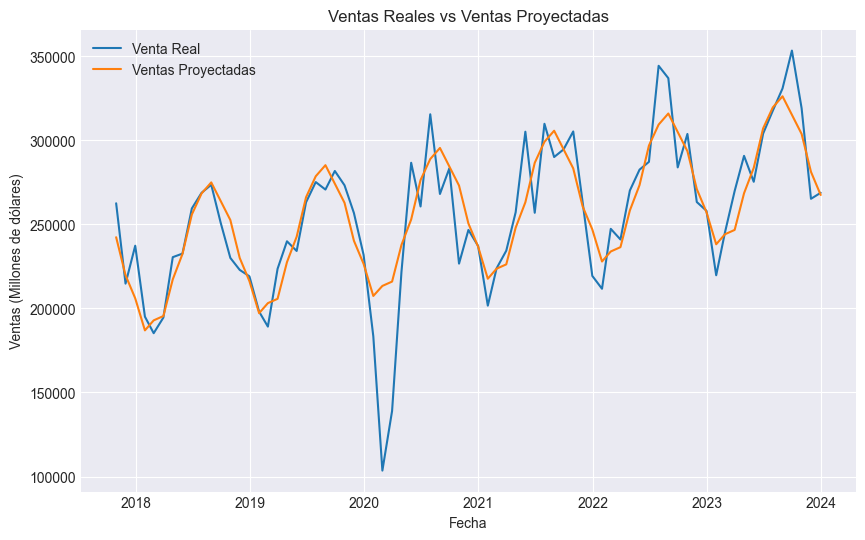

In [47]:
# Graficar las ventas reales y suavizadas
plt.figure(figsize=(10, 6))
plt.plot(predicciones_df['Fecha'], predicciones_df['Venta_Real'], label='Venta Real')
plt.plot(predicciones_df['Fecha'], predicciones_df['Ventas_Proyectadas'], label='Ventas Proyectadas')
plt.title('Ventas Reales vs Ventas Proyectadas')
plt.xlabel('Fecha')
plt.ylabel('Ventas (Millones de dólares)')
plt.legend()
plt.show()

In [48]:
# Llamar a la función de evaluación de métricas
evaluacion_metrica(datos_test['ref_doc_venta_neta'], predicciones)

Evaluation metric results:-
MSE is : 518251564.1339452
MAE is : 15092.571728686513
RMSE is : 22765.139229399527
MAPE is : 7.031055858074567
R2 is : 0.7367316801034383



# RED NEURONAL LSTM

## PRUEBA LSTM 1

In [49]:
scaler = MinMaxScaler()

In [50]:
scaler.fit(train)
scaled_train_data = scaler.transform(train)

scaled_test_data = scaler.transform(test)

In [51]:
scaled_test_data.shape

(75, 1)

In [52]:
n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

In [53]:
generator

In [54]:
# Importar las librerías necesarias
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam

# Definir el modelo
lstm_model = Sequential()
lstm_model.add(GRU(128, return_sequences=True, input_shape=(n_input, n_features)))
lstm_model.add(GRU(64, return_sequences=False))
lstm_model.add(Dense(32, activation='relu'))
lstm_model.add(Dense(1))

# Compilar el modelo
lstm_model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

# Mostrar un resumen del modelo
lstm_model.summary()





C:\Users\edwin luna\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 12, 128)        │        50,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,665 (350.25 KB)

 Trainable params: 89,665 (350.25 KB)

 Non-trainable params: 0 (0.00 B)

In [55]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
lstm_model.fit(generator, epochs=500, callbacks=[early_stop])




Epoch 1/500
 31/165 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1107

C:\Users\edwin luna\AppData\Roaming\Python\Python39\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x2208c8e1400>


165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0690
Epoch 2/500
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0168
Epoch 3/500
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0148
Epoch 4/500
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0133
Epoch 5/500
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0131
Epoch 6/500
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0112
Epoch 7/500
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0157
Epoch 8/500
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0123
Epoch 9/500
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0130
Epoch 10/500
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0129
Epoch 11/500
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0097
Epoch 12/500
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0108
Epoch 13/500
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0092
Epoch 14/500
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0096
Epoch 15/500
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step -

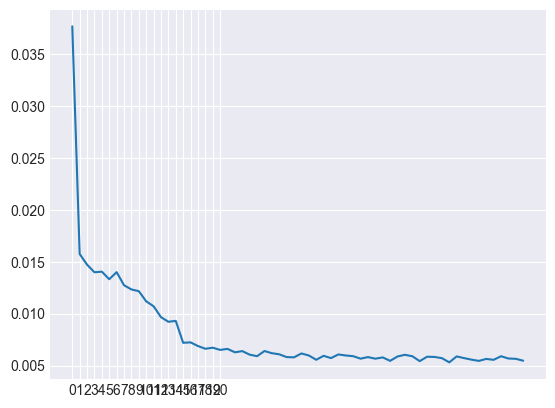

In [56]:
losses_lstm = lstm_model.history.history['loss']
#plt.figure(figsize=(12,4))
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [57]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(datos_test)):
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred)
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━

In [58]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [59]:
lstm_predictions

array([[258110.76628207],
       [236480.14991869],
       [212750.47592533],
       [195272.42154832],
       [191826.38140366],
       [197644.990006  ],
       [215280.13562452],
       [239480.91764777],
       [261167.78096034],
       [280312.71042641],
       [290955.65797047],
       [289031.71405789],
       [281260.7385435 ],
       [256868.92337398],
       [227362.68897347],
       [206526.39985243],
       [198522.33025084],
       [203362.1042833 ],
       [224073.510647  ],
       [251569.25756254],
       [278018.50277626],
       [302380.50566067],
       [315863.84129147],
       [314819.78677167],
       [303567.108533  ],
       [276248.78231376],
       [238011.93291292],
       [210373.43371302],
       [197929.6788474 ],
       [201889.58897856],
       [226057.48699345],
       [257048.17945678],
       [288753.24513745],
       [318875.65957685],
       [335979.49903698],
       [335715.96812345],
       [321326.94572277],
       [290877.01675667],
       [2422

In [60]:
datos_test['LSTM_Predictions'] = lstm_predictions

In [61]:
datos_test

ref_doc_venta_neta  LSTM_Predictions
ref_fecha                                       
2017-10-31       262508.190440     258110.766282
2017-11-30       214719.390529     236480.149919
2017-12-31       237284.609212     212750.475925
2018-01-31       195074.253244     195272.421548
2018-02-28       185250.206375     191826.381404
...                        ...               ...
2023-08-31       330801.655137     345174.097199
2023-09-30       353326.435118     346944.607897
2023-10-31       319066.757537     324876.149884
2023-11-30       265178.374151     279916.445380
2023-12-31       268767.929206     206270.975229

[75 rows x 2 columns]

In [62]:
ai=datos_test[["ref_doc_venta_neta","LSTM_Predictions"]]
fig = px.line(ai, x=datos_test.index, y=ai.columns,title="Predicción con Modelo LSTM")
fig.show()

C:\ProgramData\Anaconda3\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  v = v.dt.to_pydatetime()


C:\ProgramData\Anaconda3\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [63]:
evaluacion_metrica(datos_test["ref_doc_venta_neta"],datos_test["LSTM_Predictions"])

Evaluation metric results:-
MSE is : 1707251246.9720347
MAE is : 31928.124499951184
RMSE is : 41318.89697187032
MAPE is : 13.370790194805874
R2 is : 0.1327278130211863



In [64]:
datos_test = datos_test.drop(columns=['LSTM_Predictions'])

## PRUEBA LSTM 2

In [65]:
scaler = MinMaxScaler()

In [66]:
scaler.fit(train)
scaled_train_data = scaler.transform(train)

scaled_test_data = scaler.transform(test)

In [67]:
scaled_test_data.shape

(75, 1)

In [68]:
n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

In [69]:
generator

Epoch 1/400
 37/165 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1265

C:\Users\edwin luna\AppData\Roaming\Python\Python39\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.

sys:1: ResourceWarning:

unclosed socket <zmq.Socket(zmq.PUSH) at 0x2208f66ca00>



165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6829
Epoch 2/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0486
Epoch 3/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0448
Epoch 4/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0298
Epoch 5/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0235
Epoch 6/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0230
Epoch 7/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0237
Epoch 8/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0211
Epoch 9/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0199
Epoch 10/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0227
Epoch 11/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0200
Epoch 12/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0195
Epoch 13/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0216
Epoch 14/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0194
Epoch 15/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step -

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0190
Epoch 81/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0147
Epoch 82/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0178
Epoch 83/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0186
Epoch 84/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0165
Epoch 85/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0176
Epoch 86/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0154
Epoch 87/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0137
Epoch 88/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0153
Epoch 89/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0177
Epoch 90/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0156
Epoch 91/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0174
Epoch 92/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0156
Epoch 93/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0157
Epoch 94/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4m

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0151
Epoch 160/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0145
Epoch 161/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0142
Epoch 162/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0161
Epoch 163/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0153
Epoch 164/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0162
Epoch 165/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0149
Epoch 166/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0176
Epoch 167/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0132
Epoch 168/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0147
Epoch 169/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0154
Epoch 170/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0163
Epoch 171/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0124
Epoch 172/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0144
Epoch 173/400
165/165 ━━━━━━━━━━━━

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0155
Epoch 238/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0120
Epoch 239/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0156
Epoch 240/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0121
Epoch 241/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0127
Epoch 242/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0121
Epoch 243/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0134
Epoch 244/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0113
Epoch 245/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0148
Epoch 246/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0119
Epoch 247/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0129
Epoch 248/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0118
Epoch 249/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0121
Epoch 250/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0125
Epoch 251/400
165/165 ━━━━━━━━━━━━

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0116
Epoch 316/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0100
Epoch 317/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0124
Epoch 318/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0132
Epoch 319/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0146
Epoch 320/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0117
Epoch 321/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0115
Epoch 322/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0118
Epoch 323/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0128
Epoch 324/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0124
Epoch 325/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0135
Epoch 326/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0123
Epoch 327/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0115
Epoch 328/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0113
Epoch 329/400
165/165 ━━━━━━━━━━━━

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0105
Epoch 394/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0124
Epoch 395/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0112
Epoch 396/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0110
Epoch 397/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0126
Epoch 398/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0150
Epoch 399/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0110
Epoch 400/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0114


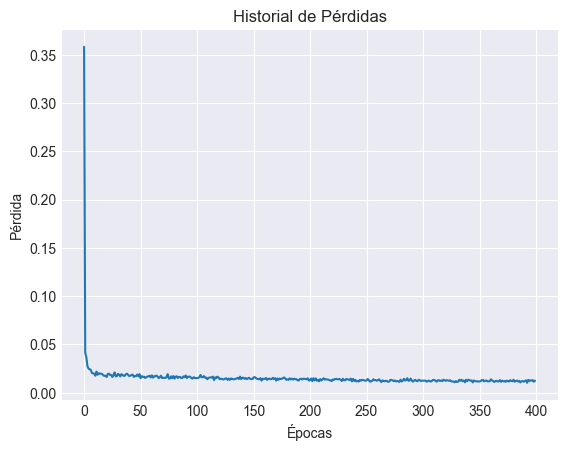

In [70]:
regularization = regularizers.l2(0.01)  

# Define el modelo LSTM
lstm_model = Sequential()
lstm_model.add(Input(shape=(n_input, n_features)))  
lstm_model.add(LSTM(100, activation='tanh', return_sequences=True, kernel_regularizer=regularization))
lstm_model.add(Dropout(0.2))  
lstm_model.add(LSTM(50, activation='relu', kernel_regularizer=regularization))
lstm_model.add(Dropout(0.2))  
lstm_model.add(Dense(1))

# Define el optimizador que deseas probar (por ejemplo, RMSprop)
optimizer = RMSprop(learning_rate=0.001)

# Compila el modelo con el nuevo optimizador
lstm_model.compile(optimizer=optimizer, loss='mse')

# Define el tamaño de lote y el número de épocas que deseas probar
batch_size = 1
epochs = 400

# Entrena el modelo con los nuevos hiperparámetros
history = lstm_model.fit(generator, epochs=epochs, batch_size=batch_size)

# Muestra un gráfico del historial de pérdidas
losses_lstm = history.history['loss']
plt.plot(range(len(losses_lstm)), losses_lstm)
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Historial de Pérdidas')
plt.show()


In [71]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(datos_test)):
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred)
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━

In [72]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [73]:
lstm_predictions

array([[240357.21274196],
       [230104.05540867],
       [218542.67535506],
       [194853.55830535],
       [203011.85135701],
       [215031.50448066],
       [228556.79908647],
       [242630.17324408],
       [251271.2876604 ],
       [256247.54307331],
       [259473.99961483],
       [250778.55011027],
       [244728.13474045],
       [237598.60132098],
       [228409.29264121],
       [218976.71877398],
       [227180.20821853],
       [236328.14422732],
       [244492.97584343],
       [250786.88582402],
       [254158.43986601],
       [255680.54884383],
       [255429.89112737],
       [251608.27227169],
       [248202.64886754],
       [243997.02636691],
       [239393.32892472],
       [237344.11988261],
       [242675.87946656],
       [247528.76886515],
       [251249.08458188],
       [253707.17695279],
       [254874.48277526],
       [255146.78275769],
       [254484.60334432],
       [252692.43763425],
       [250895.64522068],
       [248872.01687809],
       [2472

In [74]:
test_data1 = datos_test.copy()

In [75]:
test_data1['LSTM_Predictions'] = lstm_predictions

In [76]:
test_data1

ref_doc_venta_neta  LSTM_Predictions
ref_fecha                                       
2017-10-31       262508.190440     240357.212742
2017-11-30       214719.390529     230104.055409
2017-12-31       237284.609212     218542.675355
2018-01-31       195074.253244     194853.558305
2018-02-28       185250.206375     203011.851357
...                        ...               ...
2023-08-31       330801.655137     254865.943130
2023-09-30       353326.435118     254698.247433
2023-10-31       319066.757537     254559.229650
2023-11-30       265178.374151     254490.058521
2023-12-31       268767.929206     254540.416938

[75 rows x 2 columns]

In [77]:
ai=test_data1[["ref_doc_venta_neta","LSTM_Predictions"]]
fig = px.line(ai, x=test_data1.index, y=ai.columns,title="Predicción con Modelo LSTM")
fig.show()

C:\ProgramData\Anaconda3\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

C:\ProgramData\Anaconda3\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [78]:
evaluacion_metrica(test_data1["ref_doc_venta_neta"],test_data1["LSTM_Predictions"])

Evaluation metric results:-
MSE is : 1549179865.9399226
MAE is : 28875.525204451184
RMSE is : 39359.62227892847
MAPE is : 12.34691574420142
R2 is : 0.21302701477583397



## PRUEBA LSTM 3

In [79]:
scaler = MinMaxScaler()

In [80]:
scaler.fit(train)
scaled_train_data = scaler.transform(train)

scaled_test_data = scaler.transform(test)

In [81]:
scaled_test_data.shape

(75, 1)

In [82]:
n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

In [83]:
generator

Epoch 1/400
 52/165 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0550

C:\Users\edwin luna\AppData\Roaming\Python\Python39\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.

sys:1: ResourceWarning:

unclosed socket <zmq.Socket(zmq.PUSH) at 0x2208fd95580>



165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6824
Epoch 2/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0423
Epoch 3/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0355
Epoch 4/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0279
Epoch 5/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0272
Epoch 6/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0275
Epoch 7/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0261
Epoch 8/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0231
Epoch 9/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0190
Epoch 10/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0231
Epoch 11/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0228
Epoch 12/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0223
Epoch 13/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0192
Epoch 14/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0188
Epoch 15/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step -

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0147
Epoch 81/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0157
Epoch 82/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0185
Epoch 83/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0177
Epoch 84/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0154
Epoch 85/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0167
Epoch 86/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0154
Epoch 87/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0188
Epoch 88/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0152
Epoch 89/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0149
Epoch 90/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0183
Epoch 91/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0141
Epoch 92/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0143
Epoch 93/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0161
Epoch 94/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4m

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0238
Epoch 160/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0146
Epoch 161/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0167
Epoch 162/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0148
Epoch 163/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0146
Epoch 164/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0140
Epoch 165/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0139
Epoch 166/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0126
Epoch 167/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0153
Epoch 168/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0149
Epoch 169/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0155
Epoch 170/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0131
Epoch 171/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0131
Epoch 172/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0152
Epoch 173/400
165/165 ━━━━━━━━━━━━

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0117
Epoch 238/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0127
Epoch 239/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0120
Epoch 240/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0139
Epoch 241/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0145
Epoch 242/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0160
Epoch 243/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0122
Epoch 244/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0141
Epoch 245/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0134
Epoch 246/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0123
Epoch 247/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0119
Epoch 248/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0164
Epoch 249/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0119
Epoch 250/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0143
Epoch 251/400
165/165 ━━━━━━━━━━━━

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0122
Epoch 316/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0128
Epoch 317/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0135
Epoch 318/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0117
Epoch 319/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0135
Epoch 320/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0112
Epoch 321/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0124
Epoch 322/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0120
Epoch 323/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0139
Epoch 324/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0107
Epoch 325/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0138
Epoch 326/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0138
Epoch 327/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0148
Epoch 328/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0119
Epoch 329/400
165/165 ━━━━━━━━━━━━

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0123
Epoch 394/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0117
Epoch 395/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0113
Epoch 396/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0105
Epoch 397/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0149
Epoch 398/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0129
Epoch 399/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0110
Epoch 400/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0121


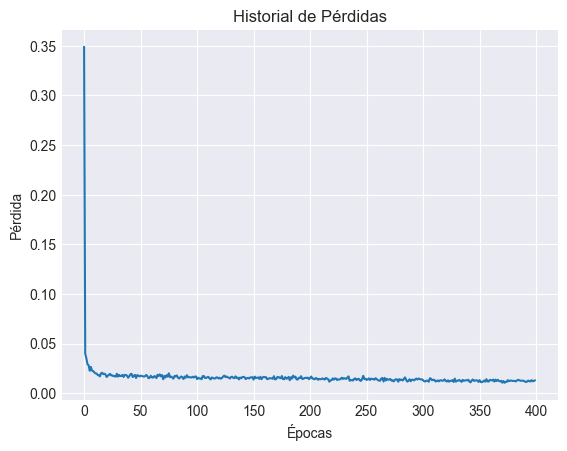

In [84]:
# Define la regularización L1 o L2 que deseas probar
regularization = regularizers.l2(0.01) 

# Define el modelo LSTM usando Input en lugar de input_shape
lstm_model = Sequential()
lstm_model.add(Input(shape=(n_input, n_features)))  
lstm_model.add(LSTM(100, activation='tanh', return_sequences=True, kernel_regularizer=regularization))
lstm_model.add(Dropout(0.2))  
lstm_model.add(LSTM(50, activation='relu', kernel_regularizer=regularization))
lstm_model.add(Dropout(0.2))  
lstm_model.add(Dense(1))

# Define el optimizador que deseas probar (por ejemplo, RMSprop)
optimizer = RMSprop(learning_rate=0.001)

# Compila el modelo con el nuevo optimizador
lstm_model.compile(optimizer=optimizer, loss='mse')

# Define el tamaño de lote y el número de épocas que deseas probar
batch_size = 1
epochs = 400

# Entrena el modelo con los nuevos hiperparámetros
history = lstm_model.fit(generator, epochs=epochs, batch_size=batch_size)

# Muestra un gráfico del historial de pérdidas
losses_lstm = history.history['loss']
plt.plot(range(len(losses_lstm)), losses_lstm)
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Historial de Pérdidas')
plt.show()


In [85]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(datos_test)):
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred)
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━

In [86]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [87]:
lstm_predictions

array([[239277.54662551],
       [228963.59211397],
       [217489.49488566],
       [195266.91538878],
       [202805.30664557],
       [214356.99993702],
       [227421.66351095],
       [241530.78946835],
       [250604.07367985],
       [255957.15688627],
       [259416.27415984],
       [249971.96146637],
       [243152.35345286],
       [235785.04825973],
       [226775.60745827],
       [218209.24680515],
       [225764.64087866],
       [234592.05977182],
       [242841.0769985 ],
       [249618.11424149],
       [253439.74584292],
       [255213.34101028],
       [254916.84961394],
       [250463.38620531],
       [246506.52230593],
       [241971.63911225],
       [237315.17430781],
       [235485.93124102],
       [240674.0718303 ],
       [245728.72628796],
       [249838.76848676],
       [252721.7528355 ],
       [254154.52692393],
       [254507.20154076],
       [253688.54268139],
       [251467.87794916],
       [249288.02507537],
       [246973.44973321],
       [2452

In [88]:
test_data2 = datos_test.copy()

In [89]:
test_data2['LSTM_Predictions'] = lstm_predictions

In [90]:
test_data2

ref_doc_venta_neta  LSTM_Predictions
ref_fecha                                       
2017-10-31       262508.190440     239277.546626
2017-11-30       214719.390529     228963.592114
2017-12-31       237284.609212     217489.494886
2018-01-31       195074.253244     195266.915389
2018-02-28       185250.206375     202805.306646
...                        ...               ...
2023-08-31       330801.655137     253980.726018
2023-09-30       353326.435118     253729.660438
2023-10-31       319066.757537     253525.040333
2023-11-30       265178.374151     253425.419632
2023-12-31       268767.929206     253497.254620

[75 rows x 2 columns]

In [91]:
ai=test_data2[["ref_doc_venta_neta","LSTM_Predictions"]]
fig = px.line(ai, x=test_data2.index, y=ai.columns,title="Predicción con Modelo LSTM")
fig.show()

C:\ProgramData\Anaconda3\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

C:\ProgramData\Anaconda3\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [92]:
evaluacion_metrica(test_data2["ref_doc_venta_neta"],test_data2["LSTM_Predictions"])

Evaluation metric results:-
MSE is : 1551079436.2156126
MAE is : 28877.89822572828
RMSE is : 39383.74583778964
MAPE is : 12.27481555056516
R2 is : 0.21206204581169386



## PRUEBA LSTM 4

In [93]:
scaler = MinMaxScaler()

In [94]:
scaler.fit(train)
scaled_train_data = scaler.transform(train)

scaled_test_data = scaler.transform(test)

In [95]:
scaled_test_data.shape

(75, 1)

In [96]:
n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

In [97]:
generator

In [98]:
batch_size=1
epochs = 600

In [99]:
# Define la función para crear el modelo LSTM
def create_lstm_model(units=100, optimizer='adam'):
    model = Sequential()
    model.add(Input(shape=(n_input, n_features)))  
    model.add(LSTM(units=units, activation='relu'))  
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Define una clase de envoltura para el modelo de Keras
class KerasWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, units=100, optimizer='adam'):
        self.units = units
        self.optimizer = optimizer
        self.model = None

    def fit(self, X, y):
        self.model = create_lstm_model(units=self.units, optimizer=self.optimizer)
        self.model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=0)
        return self

    def predict(self, X):
        return self.model.predict(X)

# Define los parámetros a buscar
param_grid = {
    'units': [50, 100, 200],
    'optimizer': ['adam', 'rmsprop']
}

# Define el esquema de validación cruzada KFold
kf = KFold(n_splits=5, shuffle=True)

# Envuelve el modelo en la clase KerasWrapper
keras_model_wrapper = KerasWrapper()

# Realiza la búsqueda de hiperparámetros utilizando GridSearchCV con KFold
grid_search = GridSearchCV(estimator=keras_model_wrapper, param_grid=param_grid, cv=kf, scoring='neg_mean_squared_error')
grid_result = grid_search.fit(scaled_train_data, scaled_train_data)

# Muestra los resultados de la búsqueda de hiperparámetros
print("Mejor MSE: {:.4f}".format(-grid_result.best_score_))
print("Mejores Parámetros: ", grid_result.best_params_)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/stepWARNING:tensorflow:5 out of the last 79 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000022090282280> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


tensorflow WARNING 5 out of the last 79 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000022090282280> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


tensorflow WARNING 6 out of the last 80 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000220918F30D0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 325ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 381ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

Epoch 1/600
 61/165 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0373

C:\Users\edwin luna\AppData\Roaming\Python\Python39\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.

sys:1: ResourceWarning:

unclosed socket <zmq.Socket(zmq.PUSH) at 0x220ac5c2dc0>



165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0292
Epoch 2/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0187
Epoch 3/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0120
Epoch 4/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0115
Epoch 5/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0112
Epoch 6/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0097
Epoch 7/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0112
Epoch 8/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0116
Epoch 9/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0098
Epoch 10/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0073
Epoch 11/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0081
Epoch 12/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0068
Epoch 13/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0119
Epoch 14/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0075
Epoch 15/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step -

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0051
Epoch 81/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0059
Epoch 82/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0061
Epoch 83/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0068
Epoch 84/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0051
Epoch 85/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0051
Epoch 86/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0063
Epoch 87/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0035
Epoch 88/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0062
Epoch 89/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0050
Epoch 90/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0064
Epoch 91/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0050
Epoch 92/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0059
Epoch 93/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0050
Epoch 94/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4m

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0042
Epoch 160/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0035
Epoch 161/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0045
Epoch 162/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0038
Epoch 163/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0036
Epoch 164/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0044
Epoch 165/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0034
Epoch 166/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0034
Epoch 167/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0035
Epoch 168/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0025
Epoch 169/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0037
Epoch 170/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0037
Epoch 171/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0039
Epoch 172/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0035
Epoch 173/600
165/165 ━━━━━━━━━━━━

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0035
Epoch 238/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0025
Epoch 239/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0025
Epoch 240/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0023
Epoch 241/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0027
Epoch 242/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0020
Epoch 243/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0024
Epoch 244/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0023
Epoch 245/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0022
Epoch 246/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0024
Epoch 247/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0024
Epoch 248/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0027
Epoch 249/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0028
Epoch 250/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0022
Epoch 251/600
165/165 ━━━━━━━━━━━━

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0013
Epoch 316/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0020
Epoch 317/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0018
Epoch 318/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0014
Epoch 319/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0013
Epoch 320/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0016
Epoch 321/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0019
Epoch 322/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0015
Epoch 323/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0020
Epoch 324/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0012
Epoch 325/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0016
Epoch 326/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0022
Epoch 327/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0015
Epoch 328/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0013
Epoch 329/600
165/165 ━━━━━━━━━━━━

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.1018e-04
Epoch 394/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.1558e-04
Epoch 395/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.2626e-04
Epoch 396/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.9521e-04
Epoch 397/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0018
Epoch 398/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.4934e-04
Epoch 399/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0016
Epoch 400/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0011
Epoch 401/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0014
Epoch 402/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.4787e-04
Epoch 403/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.8512e-04
Epoch 404/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.8602e-04
Epoch 405/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.0642e-04
Epoch 406/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.791

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7585e-04
Epoch 470/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.5452e-04
Epoch 471/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.9699e-04
Epoch 472/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.4609e-04
Epoch 473/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.3164e-04
Epoch 474/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.3232e-04
Epoch 475/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.6849e-04
Epoch 476/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0017
Epoch 477/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.8306e-04
Epoch 478/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.1508e-04
Epoch 479/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.9288e-04
Epoch 480/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.8731e-04
Epoch 481/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.2576e-04
Epoch 482/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step -

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.2314e-05
Epoch 546/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.0008e-04
Epoch 547/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.3335e-04
Epoch 548/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7363e-04
Epoch 549/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.5134e-04
Epoch 550/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.1838e-04
Epoch 551/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.4019e-04
Epoch 552/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.8216e-04
Epoch 553/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.4405e-04
Epoch 554/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.3742e-04
Epoch 555/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.4538e-04
Epoch 556/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.2016e-04
Epoch 557/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.5718e-04
Epoch 558/600
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/st

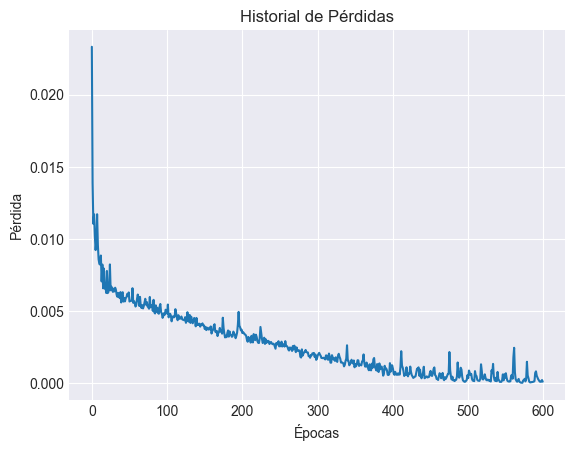

In [100]:
# Define los mejores parámetros obtenidos de la búsqueda de hiperparámetros
best_optimizer = 'adam'
best_units = 200

# Construye el modelo LSTM con los mejores parámetros
lstm_model = Sequential()
lstm_model.add(Input(shape=(n_input, n_features)))  
lstm_model.add(LSTM(units=best_units, activation='relu'))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer=best_optimizer, loss='mse')

# Entrena el modelo con los datos de entrenamiento
history = lstm_model.fit(generator, epochs=epochs, batch_size=batch_size)

# Muestra un gráfico del historial de pérdidas
losses_lstm = history.history['loss']
plt.plot(range(len(losses_lstm)), losses_lstm)
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Historial de Pérdidas')
plt.show()


In [101]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(datos_test)):
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred)
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

In [102]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [103]:
lstm_predictions

array([[260138.34580395],
       [242766.47618417],
       [202252.44744139],
       [188066.60487689],
       [188890.23457473],
       [195774.48897989],
       [223780.28216002],
       [239538.36269649],
       [258006.03453915],
       [277523.48373873],
       [270262.05740509],
       [270264.77224764],
       [265841.61820796],
       [247549.3149975 ],
       [199489.09460525],
       [204127.67713693],
       [198042.18549152],
       [222781.75542235],
       [250169.13805916],
       [257477.36674888],
       [284189.63304655],
       [294136.22984916],
       [278935.60972888],
       [288101.8358741 ],
       [274918.73888711],
       [240299.34708383],
       [224866.56331537],
       [218389.81569913],
       [231581.47782319],
       [267117.82363022],
       [276638.34310121],
       [296637.91264975],
       [313484.74701507],
       [306665.08801859],
       [318158.86466896],
       [307287.74289323],
       [297089.85108718],
       [272344.91519995],
       [2657

In [104]:
test_data3 = datos_test.copy()

In [105]:
test_data3['LSTM_Predictions'] = lstm_predictions

In [106]:
test_data3

ref_doc_venta_neta  LSTM_Predictions
ref_fecha                                       
2017-10-31       262508.190440     260138.345804
2017-11-30       214719.390529     242766.476184
2017-12-31       237284.609212     202252.447441
2018-01-31       195074.253244     188066.604877
2018-02-28       185250.206375     188890.234575
...                        ...               ...
2023-08-31       330801.655137      99302.170187
2023-09-30       353326.435118      58531.888348
2023-10-31       319066.757537      57360.696668
2023-11-30       265178.374151      63486.483970
2023-12-31       268767.929206      92624.986255

[75 rows x 2 columns]

In [107]:
ai=test_data3[["ref_doc_venta_neta","LSTM_Predictions"]]
fig = px.line(ai, x=test_data3.index, y=ai.columns,title="Predicción con Modelo LSTM")
fig.show()

C:\ProgramData\Anaconda3\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

C:\ProgramData\Anaconda3\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [108]:
evaluacion_metrica(test_data3["ref_doc_venta_neta"],test_data3["LSTM_Predictions"])

Evaluation metric results:-
MSE is : 19273563551.408432
MAE is : 95788.52208001714
RMSE is : 138829.2604295234
MAPE is : 36.592134757141594
R2 is : -8.790841062058949



## PRUEBA LSTM 5

Epoch 1/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 1.0993
Epoch 2/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0422
Epoch 3/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0293
Epoch 4/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0271
Epoch 5/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0280
Epoch 6/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0219
Epoch 7/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0241
Epoch 8/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0166
Epoch 9/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0231
Epoch 10/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0217
Epoch 11/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0165
Epoch 12/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0232
Epoch 13/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0198
Epoch 14/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0193
Epoch 15/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0149
Epoch 81/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0170
Epoch 82/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0175
Epoch 83/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0186
Epoch 84/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0176
Epoch 85/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0153
Epoch 86/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0172
Epoch 87/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0173
Epoch 88/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0162
Epoch 89/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0131
Epoch 90/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0130
Epoch 91/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0185
Epoch 92/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0152
Epoch 93/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0166
Epoch 94/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8m

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0113
Epoch 160/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0133
Epoch 161/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0136
Epoch 162/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0147
Epoch 163/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0140
Epoch 164/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0141
Epoch 165/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0159
Epoch 166/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0153
Epoch 167/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0140
Epoch 168/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0158
Epoch 169/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0127
Epoch 170/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0147
Epoch 171/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0145
Epoch 172/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0165
Epoch 173/400
165/165 ━━━━━━━━━━━━

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0137
Epoch 238/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0143
Epoch 239/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0144
Epoch 240/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0142
Epoch 241/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0127
Epoch 242/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0120
Epoch 243/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0151
Epoch 244/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0133
Epoch 245/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0164
Epoch 246/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0133
Epoch 247/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0144
Epoch 248/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0117
Epoch 249/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0127
Epoch 250/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0128
Epoch 251/400
165/165 ━━━━━━━━━━━━

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0134
Epoch 316/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0109
Epoch 317/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0124
Epoch 318/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0114
Epoch 319/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0126
Epoch 320/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0118
Epoch 321/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0105
Epoch 322/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0097
Epoch 323/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0120
Epoch 324/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0140
Epoch 325/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0131
Epoch 326/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0124
Epoch 327/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0137
Epoch 328/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0114
Epoch 329/400
165/165 ━━━━━━━━━━━━

165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0130
Epoch 394/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0124
Epoch 395/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0137
Epoch 396/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0139
Epoch 397/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0118
Epoch 398/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0115
Epoch 399/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0110
Epoch 400/400
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0120


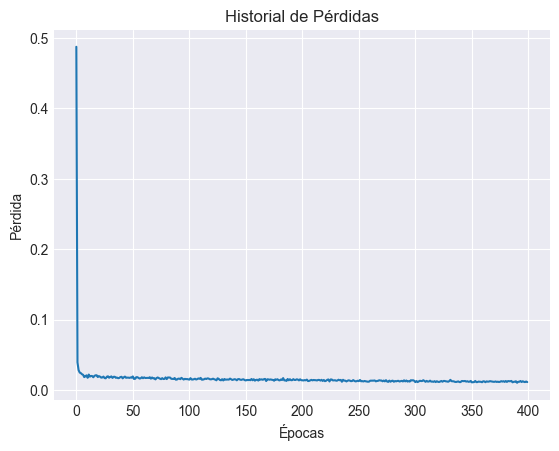

In [109]:
# Define la regularización L1 o L2 que deseas probar
regularization = regularizers.l2(0.01)  # Regularización L2 con un valor de 0.01

# Define el modelo LSTM usando Input en lugar de input_shape
lstm_model = Sequential()
lstm_model.add(Input(shape=(n_input, n_features)))  
lstm_model.add(LSTM(200, activation='tanh', return_sequences=True, kernel_regularizer=regularization))
lstm_model.add(Dropout(0.2))  
lstm_model.add(LSTM(100, activation='relu', kernel_regularizer=regularization))
lstm_model.add(Dropout(0.2))  
lstm_model.add(Dense(1))

# Define el optimizador que deseas probar (por ejemplo, RMSprop)
optimizer = RMSprop(learning_rate=0.001)

# Compila el modelo con el nuevo optimizador
lstm_model.compile(optimizer=optimizer, loss='mse')

# Define el tamaño de lote y el número de épocas que deseas probar
batch_size = 1
epochs = 400

# Entrena el modelo con los nuevos hiperparámetros
history = lstm_model.fit(generator, epochs=epochs, batch_size=batch_size)

# Muestra un gráfico del historial de pérdidas
losses_lstm = history.history['loss']
plt.plot(range(len(losses_lstm)), losses_lstm)
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Historial de Pérdidas')
plt.show()


In [110]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(datos_test)):
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred)
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━

In [111]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [112]:
lstm_predictions

array([[235623.49600934],
       [227396.72009841],
       [218105.114112  ],
       [196882.66731599],
       [204487.09425004],
       [215155.17639274],
       [226368.49578728],
       [237685.13214764],
       [244932.86955686],
       [249230.77121275],
       [251934.57595313],
       [243771.04440246],
       [237401.06784748],
       [232535.75135271],
       [226389.23310574],
       [219578.2921952 ],
       [225602.28564667],
       [232003.14512888],
       [237580.96121727],
       [242059.02390347],
       [244625.27662127],
       [245775.82179606],
       [245408.76998488],
       [242096.72580143],
       [239294.20530726],
       [236792.86664164],
       [234215.81828233],
       [233056.7462077 ],
       [236232.65314567],
       [239165.51157376],
       [241490.9080489 ],
       [243126.28841522],
       [243942.32165222],
       [244086.01712133],
       [243493.50592102],
       [242092.634419  ],
       [240867.23351509],
       [239797.44534688],
       [2390

In [113]:
test_data4 = datos_test.copy()

In [114]:
test_data4['LSTM_Predictions'] = lstm_predictions

In [115]:
test_data4

ref_doc_venta_neta  LSTM_Predictions
ref_fecha                                       
2017-10-31       262508.190440     235623.496009
2017-11-30       214719.390529     227396.720098
2017-12-31       237284.609212     218105.114112
2018-01-31       195074.253244     196882.667316
2018-02-28       185250.206375     204487.094250
...                        ...               ...
2023-08-31       330801.655137     243063.847037
2023-09-30       353326.435118     242968.253989
2023-10-31       319066.757537     242902.256549
2023-11-30       265178.374151     242879.263235
2023-12-31       268767.929206     242911.943311

[75 rows x 2 columns]

In [116]:
ai=test_data4[["ref_doc_venta_neta","LSTM_Predictions"]]
fig = px.line(ai, x=test_data4.index, y=ai.columns,title="Predicción con Modelo LSTM")
fig.show()

C:\ProgramData\Anaconda3\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

C:\ProgramData\Anaconda3\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [117]:
evaluacion_metrica(test_data4["ref_doc_venta_neta"],test_data4["LSTM_Predictions"])

Evaluation metric results:-
MSE is : 1889708035.409125
MAE is : 32782.300959095424
RMSE is : 43470.77219706507
MAPE is : 13.442032439876577
R2 is : 0.040040987799873085

